In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from pathlib import Path
from matplotlib.ticker import ScalarFormatter

In [2]:
def load_fold_data(experiment_dir, num_folds, epoch):
    """
    Generalized function to load fold data from a given experiment directory.

    Args:
        experiment_dir (str): The directory path where the experiment data is stored.
        num_folds (int): Number of folds (e.g., 3 for fold_0, fold_1, fold_2).
        epoch (int): Epoch number to be loaded (e.g., 0 for epoch_0).

    Returns:
        pd.DataFrame: A DataFrame containing the concatenated data of all folds with fold information.
    """
    dfs = []

    for fold in range(num_folds):
        file_path = os.path.join(
            experiment_dir, f"fold_{fold}_epoch_{epoch}_metrics.csv"
        )

        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            df["fold"] = fold
            dfs.append(df)
        else:
            print(f"Warning: File {file_path} does not exist.")

    if dfs:
        return pd.concat(dfs, ignore_index=True)
    else:
        print("No valid files were loaded.")
        return pd.DataFrame()  # Return an empty DataFrame if no files were found

In [3]:
register_df = pd.read_csv("/net/scratch/jmoehring/tiles_1024/register_baseline.csv")
register_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284205 entries, 0 to 284204
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        284205 non-null  int64  
 1   base_file_name    284205 non-null  object 
 2   file_path         284205 non-null  object 
 3   global_file_path  284205 non-null  object 
 4   resolution        284205 non-null  float64
 5   x                 284205 non-null  int64  
 6   y                 284205 non-null  int64  
 7   label_quality     284205 non-null  float64
 8   resolution_bin    284205 non-null  float64
 9   original          284205 non-null  bool   
 10  biome             284205 non-null  float64
dtypes: bool(1), float64(4), int64(3), object(3)
memory usage: 22.0+ MB


In [4]:
bce_metrics = load_fold_data(
    "/net/home/jmoehring/experiments/testing_runs/bce_b12", 3, 0
)
bce_metrics["experiment"] = "bce"

In [5]:
# dice_metrics = load_fold_data("/net/home/jmoehring/experiments/testing_dice/", 3, 0)
# dice_metrics["experiment"] = "dice"

In [6]:
tversky_metrics_1 = load_fold_data(
    "/net/home/jmoehring/experiments/testing_runs/tversky_a07b03g2/", 3, 0
)
tversky_metrics_1["config"] = "a07b03g2"

tversky_metrics_2 = load_fold_data(
    "/net/home/jmoehring/experiments/testing_runs/tversky_a03b08g25/", 3, 0
)
tversky_metrics_2["config"] = "a03b08g25"

tversky_metrics_3 = load_fold_data(
    "/net/home/jmoehring/experiments/testing_runs/tversky_a04b06g2/", 3, 0
)
tversky_metrics_3["config"] = "a04b06g2"

In [7]:
tversky_metrics = pd.concat(
    [tversky_metrics_1, tversky_metrics_2, tversky_metrics_3], ignore_index=True
)
tversky_metrics["experiment"] = "tversky"

In [8]:
metrics_df = pd.concat([tversky_metrics], ignore_index=True)

In [19]:
metrics_df.groupby("config").agg(
    {"precision_0.5": "mean", "recall_0.5": "mean", "f1_0.5": "mean"}
).reset_index()

,config,precision_0.5,recall_0.5,f1_0.5
0,a03b08g25,0.170724,0.129886,0.110864
1,a04b06g2,0.146913,0.090961,0.081153
2,a07b03g2,0.177306,0.045841,0.057593


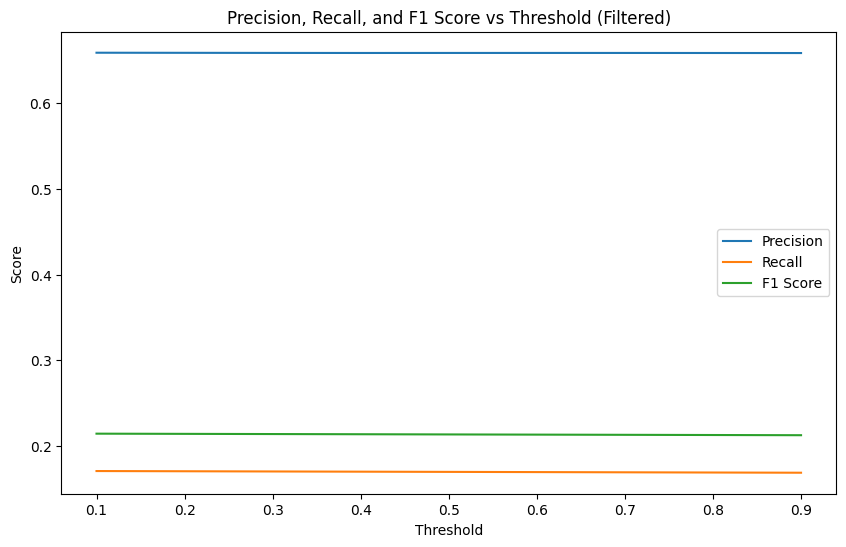

In [18]:
# Filtering the dataframe to exclude rows where all precision, recall, and f1 scores are 0 across all thresholds
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
plot_df = metrics_df[
    (metrics_df["experiment"] == "tversky") & (metrics_df["config"] == "a07b03g2")
]
plot_df = plot_df[
    (plot_df[[f"precision_{t}" for t in thresholds]] != 0).any(axis=1)
    & (plot_df[[f"recall_{t}" for t in thresholds]] != 0).any(axis=1)
    & (plot_df[[f"f1_{t}" for t in thresholds]] != 0).any(axis=1)
]
# Recalculating mean precision, recall, and f1 scores for each threshold based on the filtered dataframe
mean_precision_filtered = plot_df[[f"precision_{t}" for t in thresholds]].mean(axis=0)
mean_recall_filtered = plot_df[[f"recall_{t}" for t in thresholds]].mean(axis=0)
mean_f1_filtered = plot_df[[f"f1_{t}" for t in thresholds]].mean(axis=0)

# Creating a new dataframe for plotting
plot_data_filtered = pd.DataFrame(
    {
        "threshold": thresholds,
        "mean_precision": mean_precision_filtered.values,
        "mean_recall": mean_recall_filtered.values,
        "mean_f1": mean_f1_filtered.values,
    }
)

# Now plotting using seaborn with the filtered data
plt.figure(figsize=(10, 6))
sns.lineplot(
    x="threshold", y="mean_precision", data=plot_data_filtered, label="Precision"
)
sns.lineplot(x="threshold", y="mean_recall", data=plot_data_filtered, label="Recall")
sns.lineplot(x="threshold", y="mean_f1", data=plot_data_filtered, label="F1 Score")

plt.title("Precision, Recall, and F1 Score vs Threshold (Filtered)")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()